In [1]:
from typing import Any, Dict, List, Union, Tuple

import pandas as pd
from pandas import DataFrame
from types import ModuleType

!pip install boto3
import boto3
import json
import re
import importlib
import sys
import os
import re
import ast

!pip install statsmodels
import statsmodels.api as sm

!pip install matplotlib
import matplotlib.pyplot as plt

In [2]:
CLUSTER_PATHS = {
    "BASE": "s3://asc-clickstream-emr-output/",
    "INPUT": "behavior-platform_project_output/{provider}/{dataset}/"
    "behaviorDomain={behaviorDomain}/year={year}/month={month}/day={day}/*",
    "OUTPUT": "s3://asc-clickstream-emr-output/monitoring/pf/dataset_version={dataset}/",
    "HISTORY": "s3://asc-clickstream-emr-output/monitoring/pf_reg_history/dataset_version={dataset}/",
}

LOCAL_PATHS = {"INPUT": "C:\\Users\\malec\\PycharmProjects\\clickstream-monitoring\\resources\\pf_data"}
# DATASET = "dataset576_V10"
PROVIDER = "Datos"
INTERM_DATA_TYPE = "agg"
MODES = ["local", "cluster"]
TOP_10_PF_CLICKS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/" "top_datasets/PF_10_row_datasets.json"
)
TOP_10_PF_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PF_10_panelist_datasets.json"
)
TOP_5_PF_CLICKS_DATASETS = "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PF_5_row_datasets.json"
TOP_5_PF_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PF_5_panelist_datasets.json"
)
TOP_10_PF_CLICKS_DOMAINS = "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PF_10_row_domains.json"
TOP_10_PF_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PF_10_panelist_domains.json"
)
TOP_5_PF_CLICKS_DOMAINS = "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PF_5_row_domains.json"
TOP_5_PF_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PF_5_panelist_domains.json"
)

BLACKLIST_DOMAINS = ["exacttarget"]
blacklist_domains: List[str] = BLACKLIST_DOMAINS

In [3]:
# 1. Load top Clicks and Panelists datasets
def load_json(path: str) -> Any:
    s3 = boto3.resource("s3")
    split_path = path.split("://")[1].split("/")
    bucket = split_path[0]
    key = "/".join(split_path[1:])
    content_object = s3.Object(bucket, key)
    file_content = content_object.get()["Body"].read().decode("utf-8")
    json_file = json.loads(file_content)
    return json_file

top_10_row_datasets = load_json(TOP_10_PF_CLICKS_DATASETS)["datasets"]
top_10_panelist_datasets = load_json(TOP_10_PF_PANELISTS_DATASETS)["datasets"]

top_5_row_datasets = load_json(TOP_5_PF_CLICKS_DATASETS)["datasets"]
top_5_panelist_datasets = load_json(TOP_5_PF_PANELISTS_DATASETS)["datasets"]

top_10_row_domains = load_json(TOP_10_PF_CLICKS_DOMAINS)["domains"]
top_10_panelist_domains = load_json(TOP_10_PF_PANELISTS_DOMAINS)["domains"]

top_5_row_domains = load_json(TOP_5_PF_CLICKS_DOMAINS)["domains"]
top_5_panelist_domains = load_json(TOP_5_PF_PANELISTS_DOMAINS)["domains"]

In [4]:
# 2. Loading historic data from monitoring in the form of JSONs; this data is used for training the model

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'monitoring/pf_reg_history/dataset_version=dataset576_V11/year=2024/'  # Optional: Specify a prefix for the path in the bucket

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)
#print(objects)

# Loop through each object and load JSON into Pandas DataFrame
columns = ['name', 'result', 'domain', 'dataset', 'behavior', 'date', 'predicted', 'z_score', 'diff', 'percent_diff', 'threshold',
              'verdict']
dfs = []
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    actual_list = ast.literal_eval(content)
    #print(type(actual_list))
    dfs.extend(actual_list)

In [5]:
df = DataFrame(dfs)

In [6]:
df = df.sort_values(by=["date"]).reset_index(drop=True)

In [17]:
df[df["name"] == "count_rows_per_dataset"]

,name,result,domain,dataset,behavior,date,predicted,z_score,diff,percent_diff,threshold,verdict
261,count_rows_per_dataset,0.0,All,dataset856,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING
262,count_rows_per_dataset,0.0,All,dataset737,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING
263,count_rows_per_dataset,0.0,All,dataset11,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING
312,count_rows_per_dataset,0.0,All,dataset88,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING
313,count_rows_per_dataset,356849.0,All,other,All,1704067200000,354737.846585,1.060297,2111.153415,0.005951,2,OK
...,...,...,...,...,...,...,...,...,...,...,...,...
26223,count_rows_per_dataset,647218.0,All,other,All,1709251200000,671036.831877,0.641088,-23818.831877,-0.035496,2,OK
26248,count_rows_per_dataset,570.0,All,dataset747,All,1709251200000,277.268023,4.077594,292.731977,1.055773,2,ERROR
26253,count_rows_per_dataset,0.0,All,dataset11,All,1709251200000,0.000000,0.000000,0.000000,0.000000,2,MISSING
26278,count_rows_per_dataset,0.0,All,dataset14,All,1709251200000,0.000000,0.000000,0.000000,0.000000,2,MISSING


In [215]:
df = df[~df['domain'].isin(blacklist_domains)]

In [10]:
from datetime import datetime

# Milliseconds timestamp
milliseconds_timestamp = 1709251200000	

# Convert milliseconds to seconds
seconds_timestamp = milliseconds_timestamp / 1000.0

# Convert to datetime object
datetime_object = datetime.utcfromtimestamp(seconds_timestamp)

print(datetime_object)

##############################################################

# Define the date
date_str = "2024-02-03"

# Convert the date string to a datetime object
date_obj = datetime.strptime(date_str, "%Y-%m-%d")

# Convert the datetime object to a timestamp (in seconds)
timestamp = datetime.timestamp(date_obj)

# Convert the timestamp to milliseconds
milliseconds = int(timestamp * 1000)

print(milliseconds)

2024-03-01 00:00:00
1706918400000


In [8]:
unique_values_name = df['name'].unique()
unique_values_name

array(['count_rows_per_domain', 'count_rows_per_dataset',
       'count_behaviors_per_domain',
       'count_behaviors_with_extracted_pids_per_domain',
       'behavior_ratio_per_panelist', 'count_unique_panelists_per_domain',
       'count_unique_panelists_per_dataset'], dtype=object)

In [11]:
# count rows
count_rows = df[(df['name'] == 'count_rows')]
count_rows_per_dataset = df[(df['name'] == 'count_rows_per_dataset')]
count_rows_per_domain = df[(df['name'] == 'count_rows_per_domain')]

# count unique panelists
count_unique_panelists = df[(df['name'] == 'count_unique_panelists')]
count_unique_panelists_per_dataset = df[df["name"] == "count_unique_panelists_per_dataset"]
count_unique_panelists_per_domain = df[df["name"] == "count_unique_panelists_per_domain"]

# count behaviors
count_behaviors_per_domain = df[df["name"] == "count_behaviors_per_domain"]

# count behaviors with extracted pids
count_behaviors_with_extracted_pids_per_domain = df[df["name"] == "count_behaviors_with_extracted_pids_per_domain"]

# behavior ratio per panelist
behavior_ratio_per_panelist_per_domain = df[df["name"] == "behavior_ratio_per_panelist_per_domain"]

In [119]:
data = behavior_ratio_per_panelist_per_domain
training_set = data[data["date"] < 1706918400000]
testing_set = data[data["date"] >= 1706918400000]

In [120]:
training_set

,name,result,domain,dataset,behavior,date,predicted,z_score,diff,percent_diff,threshold,verdict


In [104]:
data = training_set.copy()
data = data.sort_values(by=["date"]).reset_index(drop=True)
data["dow"] = data["date"].apply(lambda x: pd.to_datetime(x).weekday())
data["const"] = 1
data["trend"] = data.index + 1
data["is_monday"] = data["dow"].apply(lambda x: 1 if x == 0 else 0)
data["is_tuesday"] = data["dow"].apply(lambda x: 1 if x == 1 else 0)
data["is_wednesday"] = data["dow"].apply(lambda x: 1 if x == 2 else 0)
data["is_thursday"] = data["dow"].apply(lambda x: 1 if x == 3 else 0)
data["is_friday"] = data["dow"].apply(lambda x: 1 if x == 4 else 0)
data["is_saturday"] = data["dow"].apply(lambda x: 1 if x == 5 else 0)

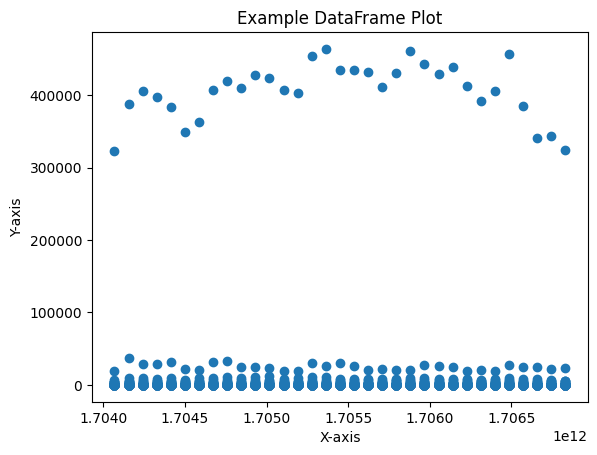

In [105]:
plt.scatter(training_set["date"], training_set["result"])
plt.title('Example DataFrame Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [106]:
X = data[["const", "trend", "is_monday", "is_tuesday", "is_wednesday", "is_thursday", "is_friday", "is_saturday"]].astype("int")
y = data["result"].astype("float")

In [107]:
# HuberT Robust Linear Regression
rlm_model_huberT = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results_huberT = rlm_model_huberT.fit()
rlm_results_huberT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:48:31                                         
No. Iterations:                    50                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2798      0.086     14.808      0.000       1.110       1.449
trend         2.045e-05   8.22e-05      0.249      0.803      -0.000       0.000
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      1.2798      0.086     14.808      0.000       1.110       1.449
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [109]:
# Trimmed Mean Robust Linear Regression
rlm_model_trimmed_mean = sm.RLM(y, X, M=sm.robust.norms.TrimmedMean())
rlm_results_trimmed_mean = rlm_model_trimmed_mean.fit()
rlm_results_trimmed_mean.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/norms.py:538: RuntimeWarning: invalid value encountered in multiply
  return test * z**2 * 0.5 + (1 - test) * self.c**2 * 0.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:48:44                                         
No. Iterations:                     8                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0        nan        nan           0           0
trend                 0          0        nan        nan           0           0
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday           0          0        nan        nan           0           0
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [110]:
# Andrew Wave Robust Linear Regression
rlm_model_andrew_wave = sm.RLM(y, X, M=sm.robust.norms.AndrewWave())
rlm_results_andrew_wave = rlm_model_andrew_wave.fit()
rlm_results_andrew_wave.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/norms.py:420: RuntimeWarning: invalid value encountered in cos
  return (test * a**2 * (1 - np.cos(z / a)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                      AndrewWave                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:49:05                                         
No. Iterations:                     9                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0        nan        nan           0           0
trend                 0          0        nan        nan           0           0
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday           0          0        nan        nan           0           0
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [111]:
# RamsayE Robust Linear Regression
rlm_model_ramsayE = sm.RLM(y, X, M=sm.robust.norms.RamsayE())
rlm_results_ramsayE = rlm_model_ramsayE.fit()
rlm_results_ramsayE.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/norms.py:315: RuntimeWarning: invalid value encountered in multiply
  return (1 - np.exp(-self.a * np.abs(z)) *


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                         RamsayE                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:49:07                                         
No. Iterations:                    12                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0        nan        nan           0           0
trend                 0          0        nan        nan           0           0
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday           0          0        nan        nan           0           0
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [112]:
# Tukey Biweight Robust Linear Regression
rlm_model_tukey_biweight = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight())
rlm_results_tukey_biweight = rlm_model_tukey_biweight.fit()
rlm_results_tukey_biweight.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/norms.py:817: RuntimeWarning: invalid value encountered in multiply
  return -(1 - (z / self.c)**2)**3 * subset * factor + factor


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:49:19                                         
No. Iterations:                     9                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0        nan        nan           0           0
trend                 0          0        nan        nan           0           0
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday           0          0        nan        nan           0           0
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [113]:
# Least Squares Robust Linear Regression
rlm_model_least_squares = sm.RLM(y, X, M=sm.robust.norms.LeastSquares())
rlm_results_least_squares = rlm_model_least_squares.fit()
rlm_results_least_squares.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:49:21                                         
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2101.8928    641.130      3.278      0.001     845.300    3358.485
trend            0.0367      0.610      0.060      0.952      -1.158       1.231
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday   2101.8928    641.130      3.278      0.001     845.300    3358.485
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [114]:
# Robust Norm Hampel Linear Regression
rlm_model_hampel = sm.RLM(y, X, M=sm.robust.norms.Hampel())
rlm_results_hampel = rlm_model_hampel.fit()
rlm_results_hampel.summary()

/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.11/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                 3643
Model:                            RLM   Df Residuals:                     3641
Method:                          IRLS   Df Model:                            1
Norm:                          Hampel                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        22:49:22                                         
No. Iterations:                    11                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0        nan        nan           0           0
trend                 0          0        nan        nan           0           0
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday           0          0        nan        nan           0           0
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [115]:
if len(testing_set) < len(training_set):
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]
else:
    testing_set = testing_set[:len(training_set)]
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]

In [116]:
def mse_mae(testing_set, predicted_values):
    #predicted_values = predicted_values[:len(testing_set)]
    mae = 0
    mse = 0
    c = 0

    for i in range(len(testing_set)):
      mse += (testing_set.result.iloc[i] - predicted_values[i])**2
      mae += abs(testing_set.result.iloc[i] - predicted_values[i])
      c += 1

    return ["{:.4e}".format(mse / c), "{:.4e}".format(mae / c), "{:.4e}".format((mse/c)**(1/2))]

table = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
table.loc["HuberT"] = mse_mae(testing_set, predicted_values_huberT)
table.loc["Trimmed Mean"] = mse_mae(testing_set, predicted_values_trimmed_mean)
table.loc["Andrew Wave"] = mse_mae(testing_set, predicted_values_andrew_wave)
table.loc["RamsayE"] = mse_mae(testing_set, predicted_values_ramsayE)
table.loc["Tukey Biweight"] = mse_mae(testing_set, predicted_values_tukey_biweight)
table.loc["Least Squares"] = mse_mae(testing_set, predicted_values_least_squares)
table.loc["Hampel"] = mse_mae(testing_set, predicted_values_hampel)

table

,MSE,MAE,RMSE
HuberT,8.9628e+08,3.1563e+03,2.9938e+04
Trimmed Mean,8.9630e+08,3.1555e+03,2.9938e+04
Andrew Wave,8.9630e+08,3.1555e+03,2.9938e+04
RamsayE,8.9630e+08,3.1555e+03,2.9938e+04
Tukey Biweight,8.9630e+08,3.1555e+03,2.9938e+04
Least Squares,8.8757e+08,6.7813e+03,2.9792e+04
Hampel,8.9630e+08,3.1555e+03,2.9938e+04


In [117]:
count_behaviors_with_extracted_pids_per_domain_table = table

In [118]:
count_rows_per_dataset_table
count_rows_per_domain_table
count_unique_panelists_per_dataset_table
count_unique_panelists_per_domain_table
count_behaviors_per_domain_table
count_behaviors_with_extracted_pids_per_domain_table

,MSE,MAE,RMSE
HuberT,8.9628e+08,3.1563e+03,2.9938e+04
Trimmed Mean,8.9630e+08,3.1555e+03,2.9938e+04
Andrew Wave,8.9630e+08,3.1555e+03,2.9938e+04
RamsayE,8.9630e+08,3.1555e+03,2.9938e+04
Tukey Biweight,8.9630e+08,3.1555e+03,2.9938e+04
Least Squares,8.8757e+08,6.7813e+03,2.9792e+04
Hampel,8.9630e+08,3.1555e+03,2.9938e+04


In [122]:
combined_table = pd.concat([count_rows_per_dataset_table, count_rows_per_domain_table, count_unique_panelists_per_dataset_table,
                            count_unique_panelists_per_domain_table, count_behaviors_per_domain_table,
                            count_behaviors_with_extracted_pids_per_domain_table])

averages = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
averages.loc["HuberT"] = combined_table.loc['HuberT', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Trimmed Mean"] = combined_table.loc['Trimmed Mean', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Andrew Wave"] = combined_table.loc['Andrew Wave', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["RamsayE"] = combined_table.loc['RamsayE', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Tukey Biweight"] = combined_table.loc['Tukey Biweight', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Least Squares"] = combined_table.loc['Least Squares', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Hampel"] = combined_table.loc['Hampel', ['MSE', 'MAE', 'RMSE']].astype(float).mean()

averages

,MSE,MAE,RMSE
HuberT,1.406813e+11,102251.550000,256001.666667
Trimmed Mean,1.539789e+11,81401.250000,269667.500000
Andrew Wave,1.539462e+11,81400.416667,269618.833333
RamsayE,1.413157e+11,98875.750000,256870.666667
Tukey Biweight,1.539462e+11,81400.416667,269618.833333
Least Squares,1.432041e+11,146084.383333,257581.500000
Hampel,1.491548e+11,88575.083333,261344.500000


In [123]:
sorted_table = averages.sort_values(by='MAE')
sorted_table

,MSE,MAE,RMSE
Andrew Wave,1.539462e+11,81400.416667,269618.833333
Tukey Biweight,1.539462e+11,81400.416667,269618.833333
Trimmed Mean,1.539789e+11,81401.250000,269667.500000
Hampel,1.491548e+11,88575.083333,261344.500000
RamsayE,1.413157e+11,98875.750000,256870.666667
HuberT,1.406813e+11,102251.550000,256001.666667
Least Squares,1.432041e+11,146084.383333,257581.500000


ValueError: x and y must have same first dimension, but have shapes (0,) and (3336,)

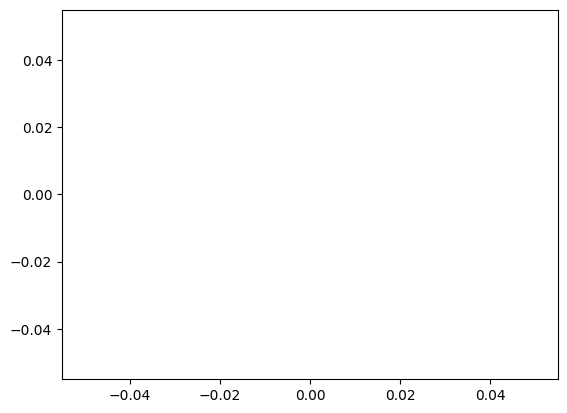

In [124]:
plt.scatter(testing_set["date"], testing_set["result"])
plt.plot(testing_set["date"], predicted_values_andrew_wave, color='orange')
plt.show()

In [244]:
data["predicted"] = rlm_results_andrew_wave.predict(X)
data["diff"] = data["result"] - data["predicted"]  # diff between predictions and reality
data["percent_diff"] = data["diff"] / (data["predicted"] + 1e-6)
data["threshold"] = 2
data["z_score"] = (abs(data["result"] - data["predicted"])) / data["diff"].std()
data["verdict"] = data.apply(lambda x: "OK" if (abs(x["z_score"]) < 2) else "NOK", axis=1)

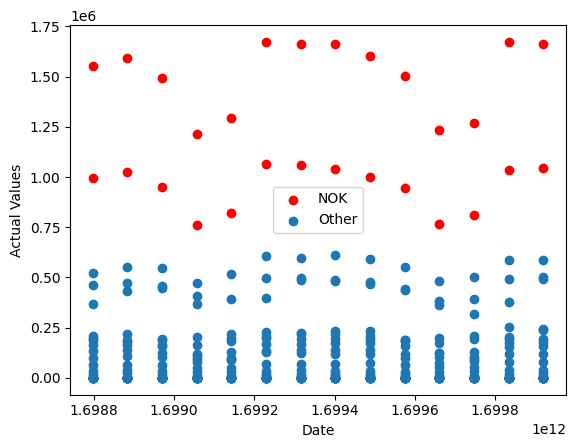

In [245]:
# Separate data based on verdict
nok_data = data[data["verdict"] == "NOK"]
other_data = data[data["verdict"] != "NOK"]

# Plot points for "NOK" verdicts with red color
plt.scatter(nok_data["date"], nok_data["result"], label='NOK', color='red')

# Plot points for other verdicts with default color
plt.scatter(other_data["date"], other_data["result"], label='Other')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Actual Values')
plt.legend()

# Show plot
plt.show()

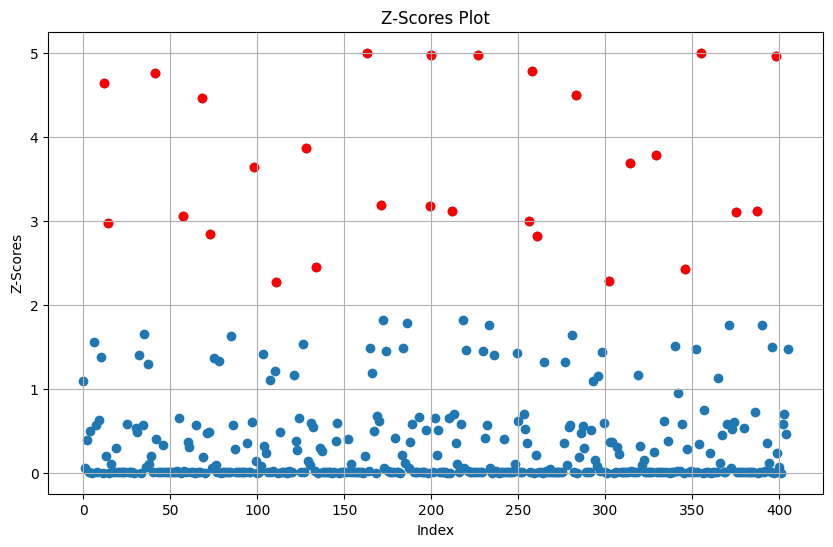

In [246]:
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data["z_score"])
plt.scatter(nok_data.index, nok_data["z_score"], label='NOK', color='red')
plt.title('Z-Scores Plot')
plt.xlabel('Index')
plt.ylabel('Z-Scores')
plt.grid(True)
plt.show()